# Customer Analytics in FMGC Industry (Part-2)
- This this notebook we are going to predict which brand customers will buy and we also will be analysing how the choice of customer would be changed as competitors' price is changing. 

### 1. Importing the libraries

In [73]:
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LogisticRegression

sns.set()
plt.rc("font", size=14)
warnings.filterwarnings("ignore")
pd.set_option('display.max_column',None)
sns.set(style="whitegrid", color_codes=True)

### 2. Loading the Data

In [74]:
purchase_df = pd.read_csv("/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/purchase data.csv", index_col=0)
price_elasticities = pd.read_csv('/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/price_elasticities.csv', index_col = 0)

#Import Scaler,PCA,KMeans
scaler = pickle.load(open('/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/scaler.pickle','rb'))
pca = pickle.load(open('/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/pca.pickle','rb'))
kmeans_pca = pickle.load(open('/Users/mac/Desktop/DataScience/Pojects_ds/Customer Analytics FMCG/kmeans_pca.pickle','rb'))

#making both of these cols as normal first by doing log normal transformation
purchase_df['age_log'] = np.log(purchase_df['Age'])
purchase_df['income_log'] = np.log(purchase_df['Income'])

#standardization
features = purchase_df[['Sex','Marital status','Education','Occupation','Settlement size','age_log','income_log']]
purchase_segm_std = scaler.transform(features)

#apply pca
purchase_segm_pca = pca.transform(purchase_segm_std)

#segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(purchase_segm_pca)

# Create a copy of the data frame
purchase_predictors = purchase_df.copy()

# Add segment labels to purchase_predictors DataFrame
purchase_predictors['Segment'] = purchase_segm_kmeans_pca

# Create segment dummies DataFrame
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix='Segment', prefix_sep='_')

# Add ID column to segment dummies DataFrame
segment_dummies['ID'] = purchase_predictors.index

# Set ID as index of segment dummies DataFrame
segment_dummies = segment_dummies.set_index('ID')

# Merge purchase_predictors and segment dummies DataFrames on ID column
purchase_predictors = pd.concat([purchase_predictors, segment_dummies], axis=1)

In [75]:
df_pa = purchase_predictors.copy()
df_pa.head()

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,age_log,income_log,Segment,Segment_0,Segment_1,Segment_2,Segment_3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0
200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0
200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0
200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0
200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0


#### Modeling Brand Choice

> The chocolate brand values are from 0-5. 0 is the value when the customer does not buy any chocolate. Hence we are going to take brand values from 1-5. By doing this we are making sure that a certain brand was purchased by the customer.<br></br>
> The final goal of this brand choice model is to determine what is the probabilty to choose a certain brand is. <b> This would help the marketers analyse customer behaviour. Based on the analysis markerters can increase the sales and certainly would also increase cstomer satisfaction. </b>

#### Brand Choice

In [76]:
brand_choice = df_pa.query('Incidence == 1')
brand_choice.head()

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,age_log,income_log,Segment,Segment_0,Segment_1,Segment_2,Segment_3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0
200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,2.62,1,0,0,0,1,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0
200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,2.67,0,0,0,1,0,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0
200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,2.68,1,1,0,0,0,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0
200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,2.37,1,0,0,1,1,0,0,47,1,110866,1,0,3.85,11.62,0,1,0,0,0


- The target variable here will be brand

In [77]:
output = brand_choice['Brand']
input =  brand_choice[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']]

#model
model_brand_choice = LogisticRegression(solver='sag',multi_class='multinomial')
model_brand_choice.fit(input,output)

LogisticRegression(multi_class='multinomial', solver='sag')

In [78]:
# Turn off scientific notation in pandas 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#doing this basically to just showcase the info in a better way
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_), columns = coefficients, index = prices)

In [79]:
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


> The dataframe bc_coef contains the beta values/weights
>- Ceof_Brand_1: The brand 1 the coef for the own brand with respect to price is negative (-3.92),while it is positive with the other prices. We know that the higher the price of the own product, the lower the probability for it to be purchased. So it makes sense for the own brand price coefficient to be negative.
>- On the other hand, the more the price of a competitor increases, the higher the probability of customers switching to our own brand would be. Hence there is a positive relationship between our own brands (Brand 5) purchase probability and a competitive brand increasing their price. 
>- It can be easily realized that the choice probability for own brand and the choice probabilities for all the other brands are interrelated and a marketing mix tool of own brand reflects not only the choice probability for that brand but the choice probabilities for all other brands as well. These effects are known as own **"Brand Effects"** and **"Cross Brand Effects"**.

#### Own Price Elasticity (For Brand 5)
Doing for Brand 5, since it is the most expensive brand. But we can always expand the findings into developing a strategy to target customers. 

In [80]:
price_range = np.arange(0.5,3.5,0.01)

In [81]:
own_brand_5 = pd.DataFrame({'Price_1': brand_choice['Price_1'].mean(),
                            'Price_2': brand_choice['Price_2'].mean(),
                            'Price_3': brand_choice['Price_3'].mean(),
                            'Price_4': brand_choice['Price_4'].mean(),
                            'Price_5': price_range}, index = np.arange(price_range.size))

In [82]:
own_brand_5.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.38,1.76,2.01,2.16,0.50
1,1.38,1.76,2.01,2.16,0.51
2,1.38,1.76,2.01,2.16,0.52
3,1.38,1.76,2.01,2.16,0.53
4,1.38,1.76,2.01,2.16,0.54


In [83]:
#brand choice model prediction
pred_brand_5 = model_brand_choice.predict_proba(own_brand_5)

# The model returns the probabilities of choosing each of the 5 brands. 
# Since, we are interested in the probability for the fifth brand we need to obtain the last column located on position 4,
# as we're starting to count from 0.
pred_own_brand_5 = pred_brand_5[: ][:, 4]

# We're interested in choosing brand 5. 
# Therefore, the beta coefficient we require is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]
np.round(beta5, 4)

-1.0879

In [84]:
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pred_own_brand_5)
price_elasticities.loc['Brand5_own_Avg'] = own_price_elasticity_brand_5
price_elasticities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.95,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.41,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.53,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.58,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.80,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

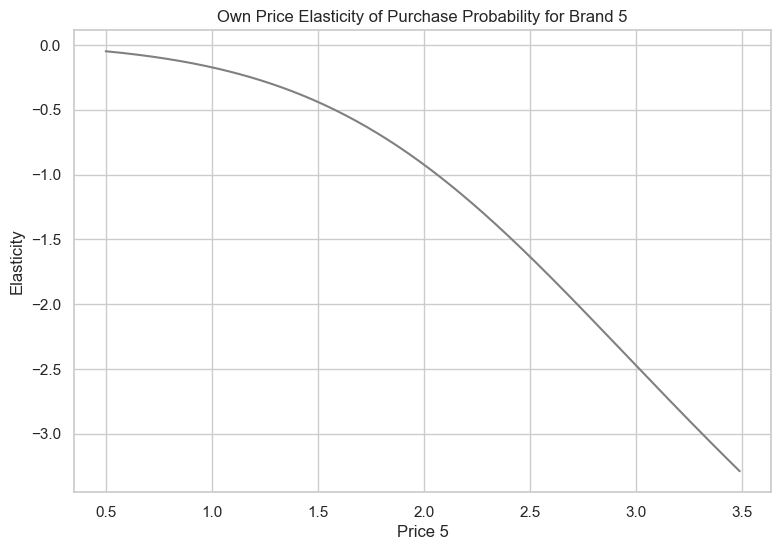

In [85]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5');

> We already saw that the beta5 is negative this means with the increase in the price of Brand5, this brand is loosing the customers.At price=0.55, they are loosing almost none.

#### Cross Price Elasticity Brand 5, Cross Brand 4
Here we are basically getting to know what effect will be on brand 5 when brand 4 increases or decreases its price. We are comapring 4,5 because they seem to be most similar.

In [86]:
brand5_cross_brand4 = pd.DataFrame({ 'B5CB4_Price1': brand_choice['Price_1'].mean(),
                                     'B5CB4_Price2': brand_choice['Price_2'].mean(),
                                     'B5CB4_Price3': brand_choice['Price_3'].mean(),
                                     'B5CB4_Price4': price_range,
                                     'B5CB5_Price5': brand_choice['Price_5'].mean()
                                     },index=np.arange(price_range.size))
brand5_cross_brand4.head()                                 

,B5CB4_Price1,B5CB4_Price2,B5CB4_Price3,B5CB4_Price4,B5CB5_Price5
0,1.38,1.76,2.01,0.50,2.65
1,1.38,1.76,2.01,0.51,2.65
2,1.38,1.76,2.01,0.52,2.65
3,1.38,1.76,2.01,0.53,2.65
4,1.38,1.76,2.01,0.54,2.65


In [87]:
#computing the prob
pred_brand5_cross_brand4 = model_brand_choice.predict_proba(brand5_cross_brand4)
#we need only for 3rd so filering out
pred_brand_4 = pred_brand5_cross_brand4[:,3]


In [88]:
#we will be using this beta value.
np.round(beta5,4)

-1.0879

$$ E = -\beta(Own Product Price)*price(Cross Brand)*Pr(Cross Brand) $$ 

Price Elasticity of Probability for Brand Choice is equal to negative the price coefficient of the own brand multiplied by the price of the cross brand,further multiplied by the probability for choosing the cross brand.


In [89]:
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pred_brand_4

In [90]:
# Update price elasticities data frame to include the cross price elasticities for brand 5 with respect to brand 4.
pd.options.display.max_columns = None
price_elasticities.loc['Brand5_Cross_Brand_4_Avg'] = brand5_cross_brand4_price_elasticity
price_elasticities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.95,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.41,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.53,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.58,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.80,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

> From the last row in the table, we examine the cross price elasticity of purchase probability for brand 5 with respect to brand 4. We can see that the values are all are positive. This implies that as the price of the competitor brand increases, so does the probability for purchasing the own brand (Brand 5). Even though the elasticity starts to decrease from the price point 1.48, it is still positive, meaning that the increase in purchase probability for the own brand happens more slowly.

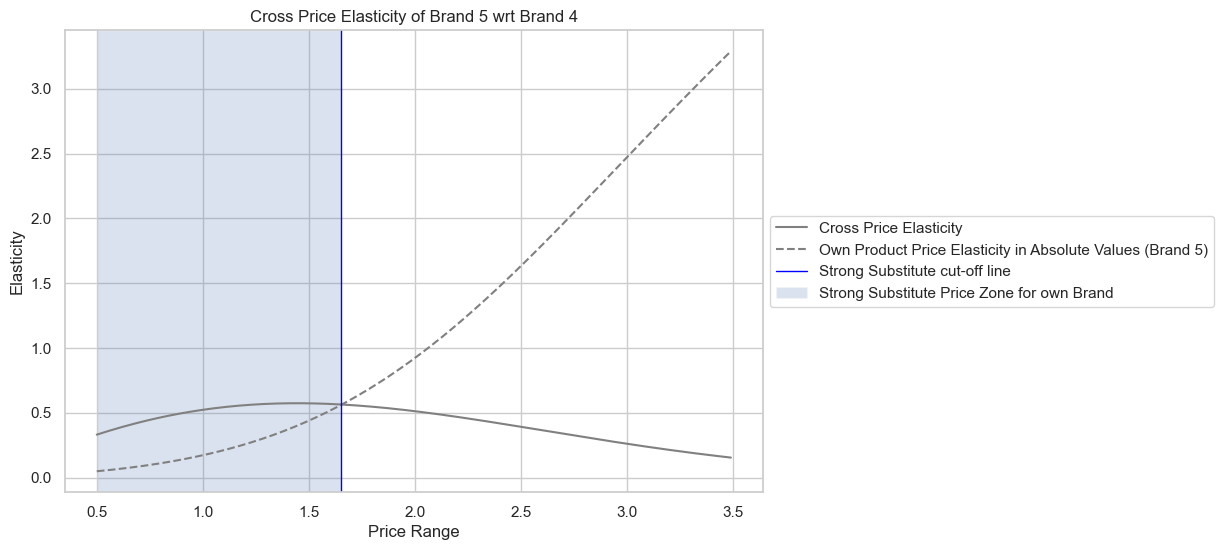

In [91]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey', label ="Cross Price Elasticity")
plt.plot(price_range, np.abs(own_price_elasticity_brand_5), color = 'grey',  
         linestyle = '--',label ="Own Product Price Elasticity in Absolute Values (Brand 5)" )
plt.xlabel('Price Range')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')
plt.axvline(x=1.65, color='blue', linewidth=1, label = "Strong Substitute cut-off line")
plt.axvspan(0.5, 1.65, facecolor='b', alpha=0.2, label = "Strong Substitute Price Zone for own Brand")
# show the legend
plt.legend( bbox_to_anchor = (1, 0.5), loc = 6)
plt.show()

>- The positive values of the elasticities across the price range indicates that if competitor brand 4 increases prices, the purchase probability for Brand 5  would increase. In other words, our competitor raises prices and they start buying our own product more, and the elasticities show us exactly how much more. <br></br>
>- If the cross price elasticity is greater than 0, the two products are considered "Substitutes". If, however we were looking at brand 5 cross some type of different products (as an example of products having nothing in common), the cross price elasticity would not be necessarily positive. <br></br>
>- In the above example all cross price elasticities are positive, since all brands are substitutes for one another. 
Furthermore, if the cross price elasticity at some price point is greater in absolute terms than our own price elasticity, the alternative brand is considered a **"Strong Substitute"**. In this sense, the Brand 4 could be strong substitute for brand 5, depending on the price point. In the graph, brand 4 is a strong substitute for brand 5 for all prices up to 1,65 (Blue-coloured Zone)
However, note that these prices are out of the natural price domain of brand 4. Therefore, if brand 4 had a substantially lower price it would be an extraordinarily strong competitor a brand 5. It is important to mark that the observed price range of brand 4 lies between 1,76(min. price) and 2,26 (max. price). Thus, when it comes to the **"average"** customer, Brand 4 is an weak substitute for brand 5. <br></br>
>-  Also, the elasticity is gradually decreasing. This signals that with an increase in price the purchase probability changes more slowly. Therefore, our purchase probability still increases with the increase in price of brand 4 but at a slower rate.


#### Own and Cross Price Elasticity by Segment
> Basically in the above analysis we saw how own product elastic price and cross price elastic (Brand5) is changing for average customers. But sometimes it might get a bit cumbersome to target all the customers sometimes also even difficult. No brand can ever make soo many customers feel satisfied. But they can always make happy or satisfied a certain group/segment. Hence now analysing <b> Own and cross Price Elastic by Customer Segments </b>


<li>Career-Focused (Segment 0)</a></li>
<li>Fewer-Opportunities (Segment 1)</a></li>
<li>Well-Off (Segment 2)</a></li>
<li>Standard (Segment 3)</a></li>

#### Well-Off(Segment 2)
 When we were analysing the segments and their preferences for the brand we got to know that well off segment prefer <b> Brand 4 </b>. Therefore it should be interesting to see their behviour wrt to the prices change in Brand4.

In [92]:
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']

In [93]:
brand_choice_WO = df_pa.query('Incidence == 1 & Segment == 2')

#finding the input and output
output_WO = brand_choice_WO['Brand']
brand_choice_WO = pd.get_dummies(brand_choice_WO, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
inputs_WO = brand_choice_WO[prices]

#model
model_brand_choice_WO = LogisticRegression(solver='sag',multi_class = 'multinomial', max_iter = 300)
model_brand_choice_WO.fit(inputs_WO,output_WO)

#coef table for well-off
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_WO.coef_),columns=coefficients,index=prices)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.37,1.22,0.83,0.34,-0.01
Price_2,-0.83,-1.39,1.22,0.73,0.27
Price_3,1.99,-1.49,-0.42,-0.09,0.01
Price_4,2.49,0.52,-0.15,-1.74,-1.12
Price_5,-0.76,-0.15,1.11,0.41,-0.61


This is giving us the information about the segment 'Well-Off' with respect to the brands and coefficients.

#### Well-Off Own-Brand Price Elasticity

In [94]:
own_brand_5_WO = pd.DataFrame({'Price1_WO_OBPE':brand_choice_WO['Price_1'].mean(),
                                'Price2_WO_OBPE':brand_choice_WO['Price_2'].mean(),
                                'Price3_WO_OBPE':brand_choice_WO['Price_3'].mean(),
                                'Price4_WO_OBPE':brand_choice_WO['Price_4'].mean(),
                                'Price5_WO_OBPE':price_range,
                            },index = np.arange(price_range.size))
own_brand_5_WO.head()

,Price1_WO_OBPE,Price2_WO_OBPE,Price3_WO_OBPE,Price4_WO_OBPE,Price5_WO_OBPE
0,1.39,1.78,2.00,2.16,0.50
1,1.39,1.78,2.00,2.16,0.51
2,1.39,1.78,2.00,2.16,0.52
3,1.39,1.78,2.00,2.16,0.53
4,1.39,1.78,2.00,2.16,0.54


In [95]:
pred_own_brand_5_WO = model_brand_choice_WO.predict_proba(own_brand_5_WO)
pr_own_brand_5_WO = pred_own_brand_5_WO[:][:,4]
own_price_elasticity_brand_5_WO = beta5 * price_range * (1-pr_own_brand_5_WO)
price_elasticities.loc['Brand5_own_PE_WellOff'] = own_price_elasticity_brand_5_WO

#### Well-Off Cross Brand Price Elasticity: Brand 5 vs 4

In [96]:
#cal cross brand price elasticity for brand 5 and brand 4
brand5_cross_brand4_WO = pd.DataFrame({ 'B5CB4_Price1': brand_choice_WO['Price_1'].mean(),
                                        'B5CB4_Price2': brand_choice_WO['Price_2'].mean(),
                                        'B5CB4_Price3': brand_choice_WO['Price_3'].mean(),
                                        'B5CB4_Price4': price_range,
                                        'B5CB4_Price5': brand_choice_WO['Price_5'].mean()
                                    }, index = np.arange(price_range.size))

pred_brand5_cross_brand4_WO = model_brand_choice_WO.predict_proba(brand5_cross_brand4_WO)
pr_cross_brand_5_WO = pred_brand5_cross_brand4_WO[: ][: , 3]
# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_WO = -beta5 * price_range * pr_cross_brand_5_WO
price_elasticities.loc['Brand5_Cross_Brand_4_WellOff'] = brand5_cross_brand4_price_elasticity_WO

In [97]:
price_elasticities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.95,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.41,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.53,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.58,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.80,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

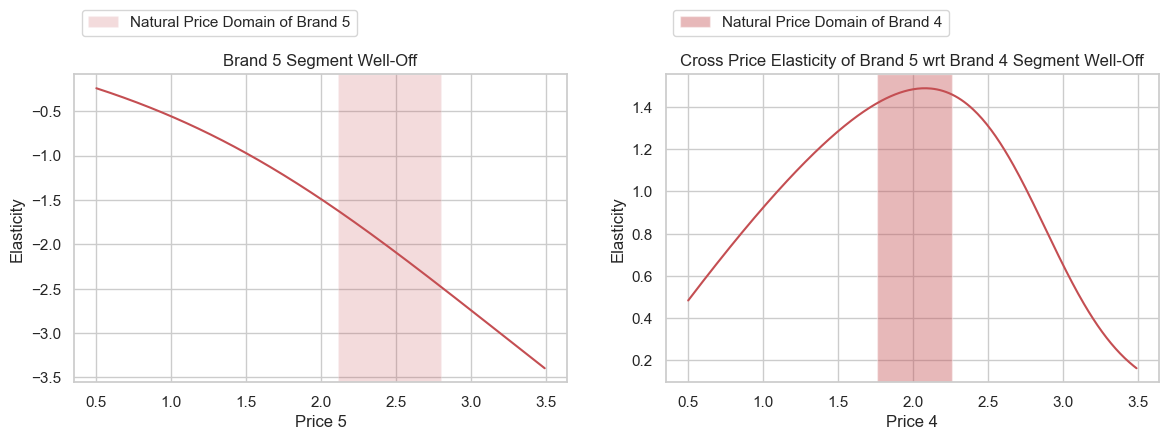

In [98]:
#Plot the own brand and cross brand price elasticites for brand 5 and 4 side by side for well off segment
fig, axs = plt.subplots(1,2,figsize=(14,4))
axs[0].plot(price_range,own_price_elasticity_brand_5_WO, color='r')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')
axs[0].axvspan(brand_choice['Price_5'].min(), brand_choice['Price_5'].max(), facecolor='r', alpha=0.2, label = "Natural Price Domain of Brand 5")

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_WO, color = 'r')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')
axs[1].axvspan(brand_choice.Price_4.min(), brand_choice.Price_4.max(), facecolor='r', alpha=0.4, label = "Natural Price Domain of Brand 4")

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')
    ax.legend(bbox_to_anchor = (0, 1.1), loc = 3)

<b>Well Off</b>

The right graph shows Cross Price Elasticity of Brand5 wrt Brand4 price range. As in when the brand4 is changing its pricing what effect it will cause to the elasticity of the Brand5.Therefore the graph clearly shows that with the increase in prices of Brand4, the elasticity of Brand drops. But when it decreases its prices,the elasticity of the Brand 5 increases.
> Notice on the above graph, the x axis has price range displayed but the left graph shows price range for brand5 while right one shows for Brand4. Also the red color region indicates the natural price range of brand 5 and 4 respectively.<br></br>
>- <b>Own Price Elasticty</b> indicates that the elasticity is conti decreasing with the increase in prices. Also this shows that the price range of brand 5 right now is not seeming to be good since the price range of brand 5 shows that 2-3 well off people are being lost due to the pricing.
>- <b>Cross Price Elasticity</b> The value to elasticity are positive indicating that for the well offs brand 4 is the substitute for brand5.<br></br>
For example: Assume that Brand 5 costs $2.40. Then the own price elasticity is -1.97. Moreover, when Brand 4 cost $2.00, the cross elasticty price is about 1.53
>- If the competitor Brand 4 decreases its price by 1%, then the cross price elasticty is 1.53, thus purchase prob of brand5 will fall by 1.53%.
>- To strike back Brand 5 can also decrease its prices by 1%. Looking into the own brand graph, a minus of 1% in the price would be also reflect a change in price elasticity, a 1% decrease in price can increase the elasticity at 1.97, since the relationof own brand and elasticity is negatively correlated. 
>- With the price elasticities, we can also react to the  competitor to keep the purchase probability constant. We establish that if brand 4 decreases their price by 1 %, the purchase probability for brand 5 would decrease by 1,53 %. Let's say, X is the decrease in price we require to reach a 1,53% increase in purchase probability. Then we can make an equation: X*2,00 = 1,53%, to match that by our own price decrease.  X is equal to 0,76%. If brand 4 decreases their price by 1 percent, we can decrease ours by 0,75% and
theoretically we will not lose a single customer from the well-off segment.

#### Standard(Segment 3)

In [99]:
brand_choice_Strd = df_pa.query('Incidence == 1 & Segment == 3')
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']

#defining input and output values
output_Strd = brand_choice_Strd['Brand']
brand_choice_Strd = pd.get_dummies(brand_choice_Strd, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
inputs_Strd = brand_choice_Strd[features]

#building model
model_brand_choice_Strd = LogisticRegression(solver='sag',multi_class='multinomial',max_iter=300)
model_brand_choice_Strd.fit(inputs_Strd,output_Strd)

#Coefficients table
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_Strd.coef_), columns = coefficients , index= features)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.87,1.39,1.48,-0.21,0.20
Price_2,1.15,-1.97,0.31,0.61,-0.09
Price_3,0.80,-0.58,0.28,-0.05,-0.45
Price_4,0.16,-0.45,0.66,-0.37,0.00
Price_5,-0.30,1.36,0.52,-0.88,-0.69


#### (Standard) Own-Brand Price Elasticity: Brand 5

In [100]:
own_brand_5_Strd = pd.DataFrame({'Price1_Strd_OBPE': brand_choice_Strd['Price_1'].mean(),
                                 'Price2_Strd_OBPE': brand_choice_Strd['Price_2'].mean(),
                                 'Price3_Strd_OBPE': brand_choice_Strd['Price_3'].mean(),
                                 'Price4_Strd_OBPE': brand_choice_Strd['Price_4'].mean(),
                                 'Price5_Strd_OBPE': price_range}, index= np.arange(price_range.size))
own_brand_5_Strd.head()

,Price1_Strd_OBPE,Price2_Strd_OBPE,Price3_Strd_OBPE,Price4_Strd_OBPE,Price5_Strd_OBPE
0,1.38,1.77,2.01,2.16,0.50
1,1.38,1.77,2.01,2.16,0.51
2,1.38,1.77,2.01,2.16,0.52
3,1.38,1.77,2.01,2.16,0.53
4,1.38,1.77,2.01,2.16,0.54


In [101]:
#getting the probabilites for the prices(Brand)
pred_own_brand_5_Strd = model_brand_choice_Strd.predict_proba(own_brand_5_Strd)

#since we only need for 5th brand so filtering out
pr_own_brand_5_Strd = pred_own_brand_5_Strd[:][:,4]

#computing elasticity and then updating 
own_price_elasticity_brand_5_Strd = beta5 * price_range * (1 - pr_own_brand_5_Strd)
price_elasticities.loc['Brand5_own_PE_Standard'] = own_price_elasticity_brand_5_Strd

In [102]:
price_elasticities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.95,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.41,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.53,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.58,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.80,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

### (Standard) Cross-Brand Price Elasticity: Brand 5 vs. 4

In [104]:
#cal cross brand price elasticity for brand5 with brand4
brand5_cross_brand4_Strd = pd.DataFrame({'B5CB4_Price_1':  brand_choice_Strd['Price_1'].mean(),
                                       'B5CB4_Price_2':  brand_choice_Strd['Price_2'].mean(), 
                                       'B5CB4_Price_3':  brand_choice_Strd['Price_3'].mean(),
                                       'B5CB4_Price_4':  price_range,
                                       'B5CB4_Price_5':  brand_choice_Strd['Price_5'].mean()},
                                        index = np.arange(price_range.size))
pred_brand5_cross_brand4_Strd = model_brand_choice_Strd.predict_proba(brand5_cross_brand4_Strd)
pr_cross_brand_5_Strd = pred_brand5_cross_brand4_Strd[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_Strd = -beta5 * price_range * pr_cross_brand_5_Strd
price_elasticities.loc['Brand5_Cross_Brand_4_Standard'] = brand5_cross_brand4_price_elasticity_Strd

#### (Standard) Visualizations

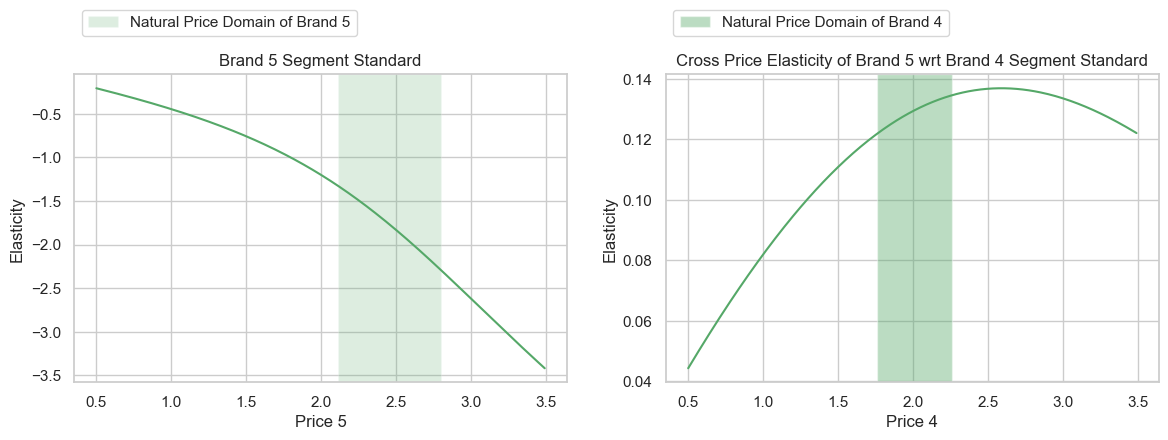

In [106]:
# Plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_Strd, color = 'g')
axs[0].set_title('Brand 5 Segment Standard')
axs[0].set_xlabel('Price 5')
axs[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='g', alpha=0.2, label = "Natural Price Domain of Brand 5")


axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_Strd, color = 'g')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Standard')
axs[1].set_xlabel('Price 4')
axs[1].axvspan(brand_choice.Price_4.min(), brand_choice.Price_4.max(), facecolor='g', alpha=0.4, label = "Natural Price Domain of Brand 4")

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')
    ax.legend(bbox_to_anchor = (0, 1.1), loc = 3)

<br> Standard Segment </br>
> From the graph we can clearly see that the rate which the brand5 has set for the segment Standard Segment is not good because they are loosing around 2-3 people for this pricing. If the company is planning to win some of the Standard Segment market, the appropriate marketing strategy would be to decrease its pricing so that they can increase the purchase probability for this segment. However, considering that this segment isn't quite homogenous and a marketing strategy based on only this segment might be risky.

#### Career-Focused (Segment 0) 

In [108]:
brand_choice_Cf = df_pa.query('Incidence == 1 & Segment == 0')

#choosing input and output
output_Cf = brand_choice_Cf['Brand']
brand_choice_Cf = pd.get_dummies(brand_choice_Cf, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
input_Cf = brand_choice_Cf[features]

#model building
model_brand_choice_Cf = LogisticRegression(solver='sag',multi_class='multinomial',max_iter=300)
model_brand_choice_Cf.fit(input_Cf,output_Cf)

# Coefficients table for Standard. 
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_Cf.coef_), columns = coefficients, index = prices)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.20,1.41,0.69,0.40,0.72
Price_2,0.84,-1.70,0.16,0.31,0.40
Price_3,1.01,0.67,1.16,-1.82,-1.02
Price_4,0.38,-0.14,1.22,-1.37,-0.08
Price_5,-0.03,0.49,-0.24,0.45,-0.67


#### (Career-Focused) Own-Brand Price Elasticity: Brand 5

In [109]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
own_brand_5_Cf = pd.DataFrame({'Price1_Cf_OBPE':  brand_choice_Cf['Price_1'].mean(),
                               'Price2_Cf_OBPE':  brand_choice_Cf['Price_2'].mean(), 
                               'Price3_Cf_OBPE':  brand_choice_Cf['Price_3'].mean(),
                               'Price4_Cf_OBPE':  brand_choice_Cf['Price_4'].mean(),
                               'Price5_Cf_OBPE':  price_range} , index = np.arange(price_range.size))

own_brand_5_Cf.head()

,Price1_Cf_OBPE,Price2_Cf_OBPE,Price3_Cf_OBPE,Price4_Cf_OBPE,Price5_Cf_OBPE
0,1.38,1.77,2.01,2.16,0.50
1,1.38,1.77,2.01,2.16,0.51
2,1.38,1.77,2.01,2.16,0.52
3,1.38,1.77,2.01,2.16,0.53
4,1.38,1.77,2.01,2.16,0.54


In [111]:
pred_own_brand_5_Cf = model_brand_choice_Cf.predict_proba(own_brand_5_Cf)
pr_own_brand_5_Cf = pred_own_brand_5_Cf[: ][: , 4]

# Compute price elasticities and update master dataframe.
own_price_elasticity_brand_5_Cf =  beta5 * price_range * (1 - pr_own_brand_5_Cf) 
price_elasticities.loc['Brand5_own_PE_Career_Focused'] = own_price_elasticity_brand_5_Cf

#### (Career-Focused) Cross-Brand Price Elasticity: Brand 5 vs. 4

In [112]:
# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
brand5_cross_brand4_Cf = pd.DataFrame({'B5CB4_Price_1':  brand_choice_Cf['Price_1'].mean(),
                                       'B5CB4_Price_2':  brand_choice_Cf['Price_2'].mean(), 
                                       'B5CB4_Price_3':  brand_choice_Cf['Price_3'].mean(),
                                       'B5CB4_Price_4':  price_range,
                                       'B5CB4_Price_5':  brand_choice_Cf['Price_5'].mean()},
                                        index = np.arange(price_range.size))

pred_brand5_cross_brand4_Cf = model_brand_choice_Cf.predict_proba(brand5_cross_brand4_Cf)
pr_cross_brand_5_Cf = pred_brand5_cross_brand4_Cf[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_Cf = -beta5 * price_range * pr_cross_brand_5_Cf
price_elasticities.loc['Brand5_Cross_Brand_4_Career_Focused'] = brand5_cross_brand4_price_elasticity_Cf


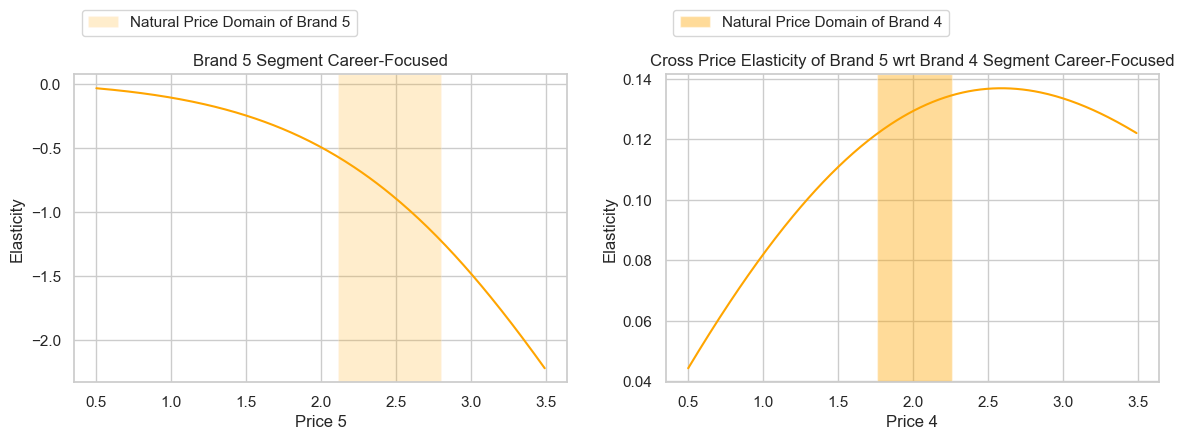

In [113]:
# Plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_Cf, color = 'orange')
axs[0].set_title('Brand 5 Segment Career-Focused')
axs[0].set_xlabel('Price 5')
axs[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='orange', alpha=0.2, label = "Natural Price Domain of Brand 5")


axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_Strd, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Career-Focused')
axs[1].set_xlabel('Price 4')
axs[1].axvspan(brand_choice.Price_4.min(), brand_choice.Price_4.max(), facecolor='orange', alpha=0.4, label = "Natural Price Domain of Brand 4")


for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')
    ax.legend(bbox_to_anchor = (0, 1.1), loc = 3)

#### Career Focused 

Career Focused customers are the least elastic among the rest. They seem to be inelastic throughout the whole price range.
In other words, it means that this segment is not really affected by the increase in the price of the own brand.

In addition, the values of cross price elasticity in this segment is also exceptionally low. This type of customers is unlikely to switch to the competitor brand. They are loyal to the brand and the company could increase prices of its own brand without fear of losing too much market share.

### Fewer-Opportunities (Segment 1) 


In [120]:
brand_choice_FO= df_pa.query('Incidence ==1 & Segment == 1')

# Brand Choice Model estimation.
output_FO = brand_choice_FO['Brand']
brand_choice_FO = pd.get_dummies(brand_choice_FO, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
inputs_FO = brand_choice_FO[features]

model_brand_choice_FO = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_FO.fit(inputs_FO, output_FO)

# Coefficients table for Standard. 
bc_coef_FO = pd.DataFrame(np.transpose(model_brand_choice_FO.coef_), columns = coefficients, index = prices)
bc_coef_FO

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.64,1.18,1.39,0.26,0.81
Price_2,0.43,-2.15,0.31,0.27,1.13
Price_3,1.52,-0.22,0.24,-0.32,-1.22
Price_4,1.25,-0.04,1.14,-1.69,-0.66
Price_5,0.62,0.96,0.77,0.13,-2.49


#### (Fewer-Opportunities) Own-Brand Price Elasticity: Brand 5

In [121]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
own_brand_5_FO = pd.DataFrame({'Price1_FO_OBPE':  brand_choice_FO['Price_1'].mean(),
                               'Price2_FO_OBPE':  brand_choice_FO['Price_2'].mean(), 
                               'Price3_FO_OBPE':  brand_choice_FO['Price_3'].mean(),
                               'Price4_FO_OBPE':  brand_choice_FO['Price_4'].mean(),
                               'Price5_FO_OBPE':  price_range} , index = np.arange(price_range.size))

own_brand_5_FO.head()

,Price1_FO_OBPE,Price2_FO_OBPE,Price3_FO_OBPE,Price4_FO_OBPE,Price5_FO_OBPE
0,1.38,1.75,2.01,2.16,0.50
1,1.38,1.75,2.01,2.16,0.51
2,1.38,1.75,2.01,2.16,0.52
3,1.38,1.75,2.01,2.16,0.53
4,1.38,1.75,2.01,2.16,0.54


In [122]:
pred_own_brand_5_FO = model_brand_choice_FO.predict_proba(own_brand_5_FO)
pr_own_brand_5_FO = pred_own_brand_5_FO[: ][: , 4]

# Compute price elasticities and update master dataframe.
own_price_elasticity_brand_5_FO =  beta5 * price_range * (1 - pr_own_brand_5_FO) 
price_elasticities.loc['Brand5_own_PE_Fewer_Opportunities'] = own_price_elasticity_brand_5_FO

In [123]:
# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the Fewer_Opportunities. 
brand5_cross_brand4_FO = pd.DataFrame({'B5CB4_Price_1':  brand_choice_FO['Price_1'].mean(),
                                       'B5CB4_Price_2':  brand_choice_FO['Price_2'].mean(), 
                                       'B5CB4_Price_3':  brand_choice_FO['Price_3'].mean(),
                                       'B5CB4_Price_4':  price_range,
                                       'B5CB4_Price_5':  brand_choice_FO['Price_5'].mean()},
                                        index = np.arange(price_range.size))

pred_brand5_cross_brand4_FO = model_brand_choice_FO.predict_proba(brand5_cross_brand4_FO)
pr_cross_brand_5_FO = pred_brand5_cross_brand4_FO[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_FO = -beta5 * price_range * pr_cross_brand_5_FO
price_elasticities.loc['Brand5_Cross_Brand_4_Fewer_Opportunities'] = brand5_cross_brand4_price_elasticity_FO
pd.options.display.max_columns = None
price_elasticities.to_csv('price_elasticities_2.csv')
price_elasticities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.95,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.41,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.53,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.58,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.80,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

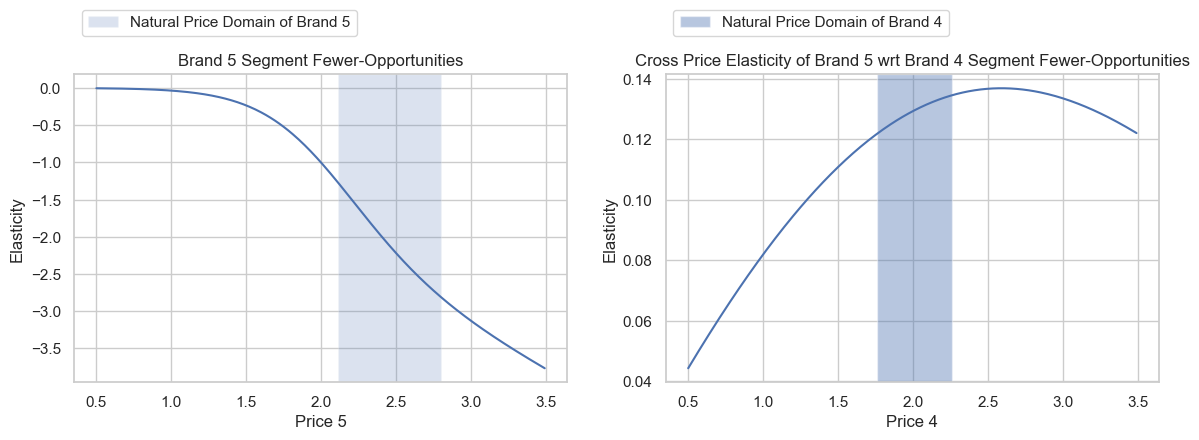

In [124]:
# Plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_FO, color = 'b')
axs[0].set_title('Brand 5 Segment Fewer-Opportunities')
axs[0].set_xlabel('Price 5')
axs[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='b', alpha=0.2, label = "Natural Price Domain of Brand 5")


axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_Strd, color = 'b')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Fewer-Opportunities')
axs[1].set_xlabel('Price 4')
axs[1].axvspan(brand_choice.Price_4.min(), brand_choice.Price_4.max(), facecolor='b', alpha=0.4, label = "Natural Price Domain of Brand 4")


for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')
    ax.legend(bbox_to_anchor = (0, 1.1), loc = 3)

#### Fewer Opportunities segment

The own price elasticity (left plot) has a more pronounced shape. This segment seems to be inelastic at lower price points and then customers become rapidly elastic at higher prices. Considering the natural price range (blue-coloured area) of the brand_5, this segment customers are rather elastic. As for Career-Focused segment, Fewer Opportunities seem loyal to brand 5, comparing to brand 4, according to the Cross price elasticity. 

As shown in descriptive analysis (Part 2-1), Fewer-Opportunities segment almost never buys brand 5 nor brand 4. The correlations are 0.066 and 0.098, respectively. This means we don't have enough observations to obtain an accurate model and that could be the reason why both curves look so out of character. Therefore, to target this segment in particular brand 5, more purchase data especially from this segment of people are necessary. However, if a product may be too pricey for a segment, we may never obtain more data about their behaviour. These people are simply not the target group for Brand 5.

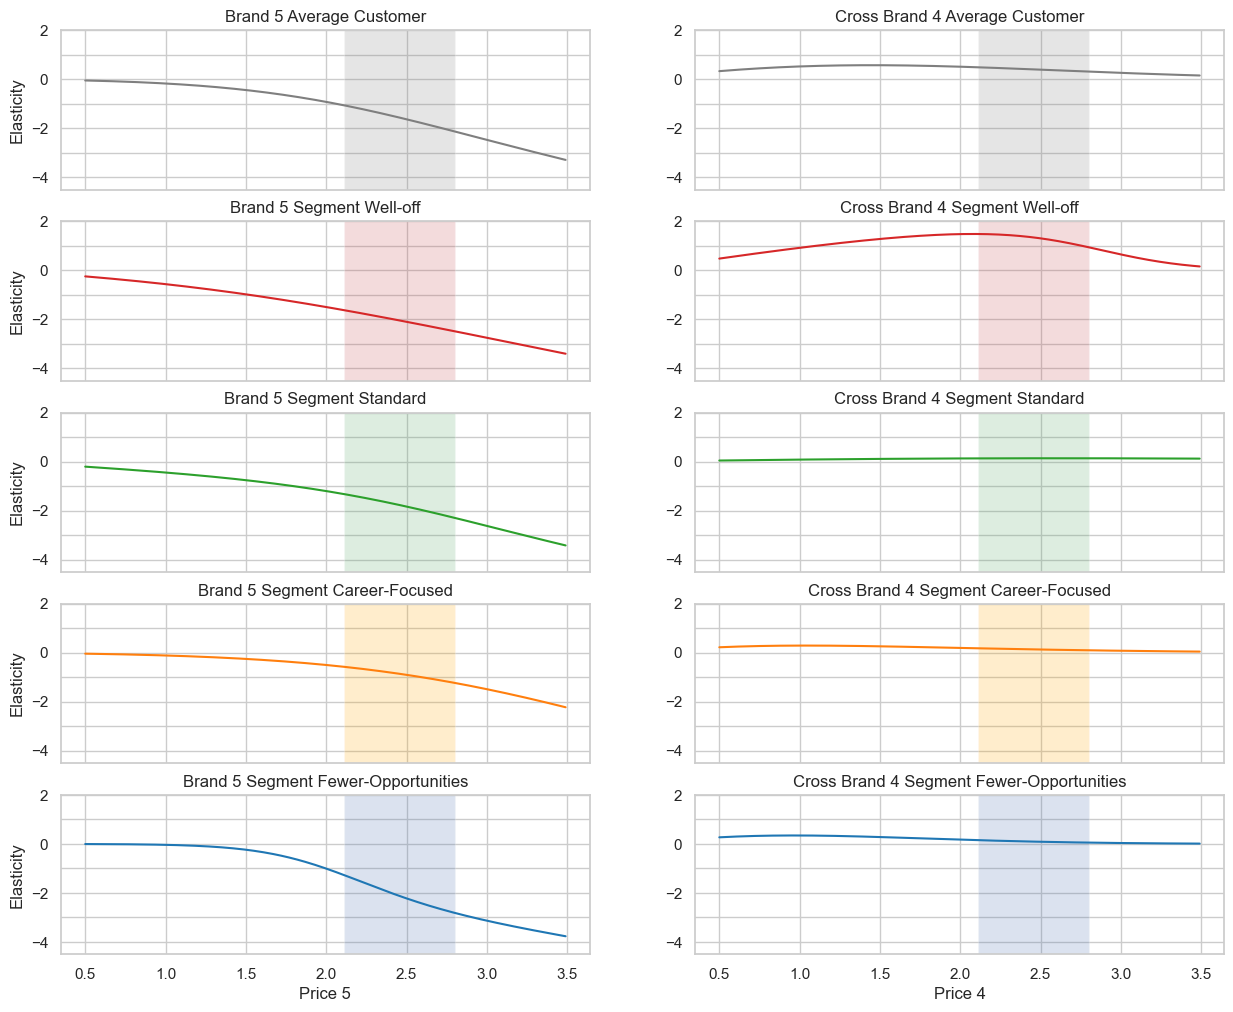

In [125]:
#plot the own and cross brand price elasticities for the average customer and each of the four segments.
minor_ticks = np.arange(-4, 2, 1)
custom_ylim = (-4.5, 2.0)
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (15, 12), sharex = True )

# Average
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[0].set_ylim([-4.5, 2.0])
ax1[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='grey', alpha=0.2)
ax1[0].set_yticks(minor_ticks, minor=True)
ax1[0].grid(  which = 'minor', axis = 'y' )

ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')
ax1[1].set_ylim([-4.5, 2.0])
ax1[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='grey', alpha=0.2)
ax1[1].set_yticks(minor_ticks, minor=True)
ax1[1].grid(  which = 'minor', axis = 'y' )

# Well-off
ax2[0].plot(price_range, own_price_elasticity_brand_5_WO, 'tab:red')
ax2[0].set_title('Brand 5 Segment Well-off')
ax2[0].set_ylabel('Elasticity')
ax2[0].set_ylim([-4.5, 2.0])
ax2[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='r', alpha=0.2)
ax2[0].set_yticks(minor_ticks, minor=True)
ax2[0].grid(  which = 'minor', axis = 'y' )

ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_WO, 'tab:red')
ax2[1].set_title('Cross Brand 4 Segment Well-off')
ax2[1].set_ylim([-4.5, 2.0])
ax2[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='r', alpha=0.2)
ax2[1].set_yticks(minor_ticks, minor=True)
ax2[1].grid(  which = 'minor', axis = 'y' )


# Standard Segment
ax3[0].plot(price_range, own_price_elasticity_brand_5_Strd, 'tab:green')
ax3[0].set_title('Brand 5 Segment Standard')
ax3[0].set_ylabel('Elasticity')
ax3[0].set_ylim([-4.5, 2.0])
ax3[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='g', alpha=0.2)
ax3[0].set_yticks(minor_ticks, minor=True)
ax3[0].grid(  which = 'minor', axis = 'y' )
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_Strd, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Standard')
ax3[1].set_ylim([-4.5, 2.0])
ax3[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='g', alpha=0.2)
ax3[1].set_yticks(minor_ticks, minor=True)
ax3[1].grid(  which = 'minor', axis = 'y' )

# Career-Focused
ax4[0].plot(price_range, own_price_elasticity_brand_5_Cf, 'tab:orange')
ax4[0].set_title('Brand 5 Segment Career-Focused')
ax4[0].set_ylabel('Elasticity')
ax4[0].set_ylim([-4.5, 2.0])
ax4[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='orange', alpha=0.2)
ax4[0].set_yticks(minor_ticks, minor=True)
ax4[0].grid(  which = 'minor', axis = 'y' )
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_Cf, 'tab:orange')
ax4[1].set_title('Cross Brand 4 Segment Career-Focused')
ax4[1].set_ylim([-4.5, 2.0])
ax4[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='orange', alpha=0.2)
ax4[1].set_yticks(minor_ticks, minor=True)
ax4[1].grid(  which = 'minor', axis = 'y' )

# Fewer-Opportunities
ax5[0].plot(price_range, own_price_elasticity_brand_5_FO, 'tab:blue')
ax5[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[0].set_ylim([-4.5, 2.0])
ax5[0].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='b', alpha=0.2)
ax5[0].set_yticks(minor_ticks, minor=True)
ax5[0].grid(  which = 'minor', axis = 'y' )

ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_FO, 'tab:blue')
ax5[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')
ax5[1].set_xlabel('Price 4')
ax5[1].set_ylim([-4.5, 2.0])
ax5[1].axvspan(brand_choice.Price_5.min(), brand_choice.Price_5.max(), facecolor='b', alpha=0.2)
ax5[1].set_yticks(minor_ticks, minor=True)
ax5[1].grid(  which = 'minor', axis = 'y' )

To get more insights, all own price elasticities and cross price elasticities are presented side by side. The two plots in the first row represents the average customer, while the following lines represent each segment.  Also, the plots are presented with shared y and x axis. It is better to compare the plots with the findings of descriptive analysis (Part 2-1). 

It seems that Career-Focused and Well-Off segments require the most attention as both groups are actually the people that purchase brand 5. Well-off segment is much more elastic than the Career-Focused. In other words, increasing the prices would barely affect the Career-Focused segment but would seriously damage Well-Off segment sales. 

If brand 4 were to decrease their price, then it would affect the Well-Off segment, but not the career focused one. A tiny decrease in our pricing would compensate such a competitor move. If prices of chocolates were to drop, we would have space to decrease our price offering while gaining solid market share from the Well-Off segment and practically retaining the Career-Focused customer base.